# Importing Libraries

In [72]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier # K-nearest Neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, r2_score, mean_squared_error
from sklearn.metrics import plot_confusion_matrix,confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import xgboost as xgb
from keras import models, optimizers
from keras import layers
np.random.seed(42)
%matplotlib inline

# Initial Setup

In [2]:
raw_data = pd.read_csv("Data/nfl_pbp_cleaned_dataset")
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349938 entries, 0 to 349937
Data columns (total 38 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   play_id                     349938 non-null  int64  
 1   game_id                     349938 non-null  int64  
 2   posteam                     349938 non-null  object 
 3   defteam                     349938 non-null  object 
 4   yardline_100                349938 non-null  int64  
 5   game_date                   349938 non-null  object 
 6   quarter_seconds_remaining   349938 non-null  int64  
 7   half_seconds_remaining      349938 non-null  int64  
 8   game_seconds_remaining      349938 non-null  float64
 9   game_half                   349938 non-null  object 
 10  sp                          349938 non-null  int64  
 11  qtr                         349938 non-null  int64  
 12  down                        349938 non-null  object 
 13  goal_to_go    

In [3]:
model_dataset = raw_data.drop(columns = ['pass_length','pass_location',
                                        'air_yards','yards_after_catch', 'run_location',
                                        'run_gap', 'qb_scramble', 'qb_dropback', 'desc',
                                        'play_id','game_id', 'game_date', 'yards_gained',
                                        'sp'])
model_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349938 entries, 0 to 349937
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   posteam                     349938 non-null  object 
 1   defteam                     349938 non-null  object 
 2   yardline_100                349938 non-null  int64  
 3   quarter_seconds_remaining   349938 non-null  int64  
 4   half_seconds_remaining      349938 non-null  int64  
 5   game_seconds_remaining      349938 non-null  float64
 6   game_half                   349938 non-null  object 
 7   qtr                         349938 non-null  int64  
 8   down                        349938 non-null  object 
 9   goal_to_go                  349938 non-null  int64  
 10  ydsnet                      349938 non-null  int64  
 11  play_type                   349938 non-null  object 
 12  shotgun                     349938 non-null  int64  
 13  no_huddle     

In [4]:
# Establish predictor and result variables
X = model_dataset.drop('play_type', axis=1)  
y = model_dataset['play_type']

In [5]:
data_dummies = pd.get_dummies(X)

In [6]:
data_dummies.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349938 entries, 0 to 349937
Data columns (total 104 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   yardline_100                          int64  
 1   quarter_seconds_remaining             int64  
 2   half_seconds_remaining                int64  
 3   game_seconds_remaining                float64
 4   qtr                                   int64  
 5   goal_to_go                            int64  
 6   ydsnet                                int64  
 7   shotgun                               int64  
 8   no_huddle                             int64  
 9   posteam_timeouts_remaining            int64  
 10  defteam_timeouts_remaining            int64  
 11  posteam_score                         int64  
 12  defteam_score                         int64  
 13  wp                                    float64
 14  def_wp                                float64
 15  posteam_home    

In [7]:
# Create a train-test split of the data, with 25% of the data set aside for testing
X_train, X_test, y_train, y_test = train_test_split(data_dummies, y, test_size=0.25, random_state=42)

In [8]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(data_dummies)
# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

# Convert into a DataFrame
scaled_df_train = pd.DataFrame(scaled_data_train, columns=X_train.columns)
scaled_df_train.head()

,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,qtr,goal_to_go,ydsnet,shotgun,no_huddle,posteam_timeouts_remaining,...,scor_diff_behind_by_one_score,scor_diff_behind_by_three_scores,scor_diff_behind_by_two_scores,scor_diff_tied,yards_for_first_down_0-3,yards_for_first_down_10,yards_for_first_down_11-15,yards_for_first_down_16+,yards_for_first_down_4-6,yards_for_first_down_7-9
0,-1.393524,1.661454,0.064897,0.901909,-0.492552,-0.247431,1.598835,-1.073269,-0.308081,0.587827,...,-0.587469,-0.246806,-0.387012,2.091557,-0.379006,1.010707,-0.270691,-0.207442,-0.398573,-0.391852
1,1.448025,-0.216676,0.791924,1.277606,-1.376883,-0.247431,-1.346208,0.931733,-0.308081,0.587827,...,-0.587469,-0.246806,-0.387012,2.091557,-0.379006,-0.989407,3.694245,-0.207442,-0.398573,-0.391852
2,-0.541059,1.365102,1.581850,1.685806,-1.376883,-0.247431,0.499352,-1.073269,-0.308081,0.587827,...,-0.587469,-0.246806,-0.387012,2.091557,-0.379006,1.010707,-0.270691,-0.207442,-0.398573,-0.391852
3,1.123276,-0.605638,0.597681,-0.543520,0.391780,-0.247431,-1.267674,-1.073269,-0.308081,0.587827,...,-0.587469,-0.246806,-0.387012,-0.478113,-0.379006,1.010707,-0.270691,-0.207442,-0.398573,-0.391852
4,-2.002427,-1.431719,0.185144,0.964047,-1.376883,4.041525,0.656421,-1.073269,-0.308081,0.587827,...,1.702218,-0.246806,-0.387012,-0.478113,2.638478,-0.989407,-0.270691,-0.207442,-0.398573,-0.391852


# Defined Functions

In [9]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average= 'weighted')))
    print("Recall Score: {}".format(recall_score(labels, preds,average='weighted')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds,average= 'weighted')))

In [22]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(12,20))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), scaled_df_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [81]:
def print_confusion_matrix(model,model_name):
    plt.figure(figsize =(10,10))
    plot_confusion_matrix(model, X_test, y_test,
                         cmap=plt.cm.Blues,normalize='true')
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontsize='small'  
    )
    plt.title(model_name + ' Confusion Matrix')
    plt.show()

# Logistic Regression

In [11]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear', random_state=42)
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

In [13]:
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[39183 12307]
 [12176 23819]]


In [14]:
print(confusion_matrix(y_test, y_hat_test))
print(classification_report(y_test, y_hat_test))

[[39183 12307]
 [12176 23819]]
              precision    recall  f1-score   support

        pass       0.76      0.76      0.76     51490
         run       0.66      0.66      0.66     35995

    accuracy                           0.72     87485
   macro avg       0.71      0.71      0.71     87485
weighted avg       0.72      0.72      0.72     87485



In [15]:
print_metrics(y_test, y_hat_test)

Precision Score: 0.7203014301644772
Recall Score: 0.7201463107961364
Accuracy Score: 0.7201463107961364
F1 Score: 0.7202222462892122


<Figure size 720x720 with 0 Axes>

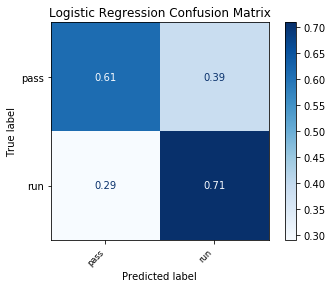

In [83]:
print_confusion_matrix(model_log, 'Logistic Regression')

# Decision Trees

In [75]:
# Train a DT classifier
classifier = DecisionTreeClassifier(random_state=42,class_weight = 'balanced',
                                    max_features = 'auto')  
classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [76]:
y_pred = classifier.predict(X_test)

In [77]:
print_metrics(y_test, y_pred)

Precision Score: 0.6542142106678279
Recall Score: 0.6543178830656684
Accuracy Score: 0.6543178830656684
F1 Score: 0.6542656049038746


In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        pass       0.71      0.71      0.71     51490
         run       0.58      0.58      0.58     35995

    accuracy                           0.65     87485
   macro avg       0.64      0.64      0.64     87485
weighted avg       0.65      0.65      0.65     87485



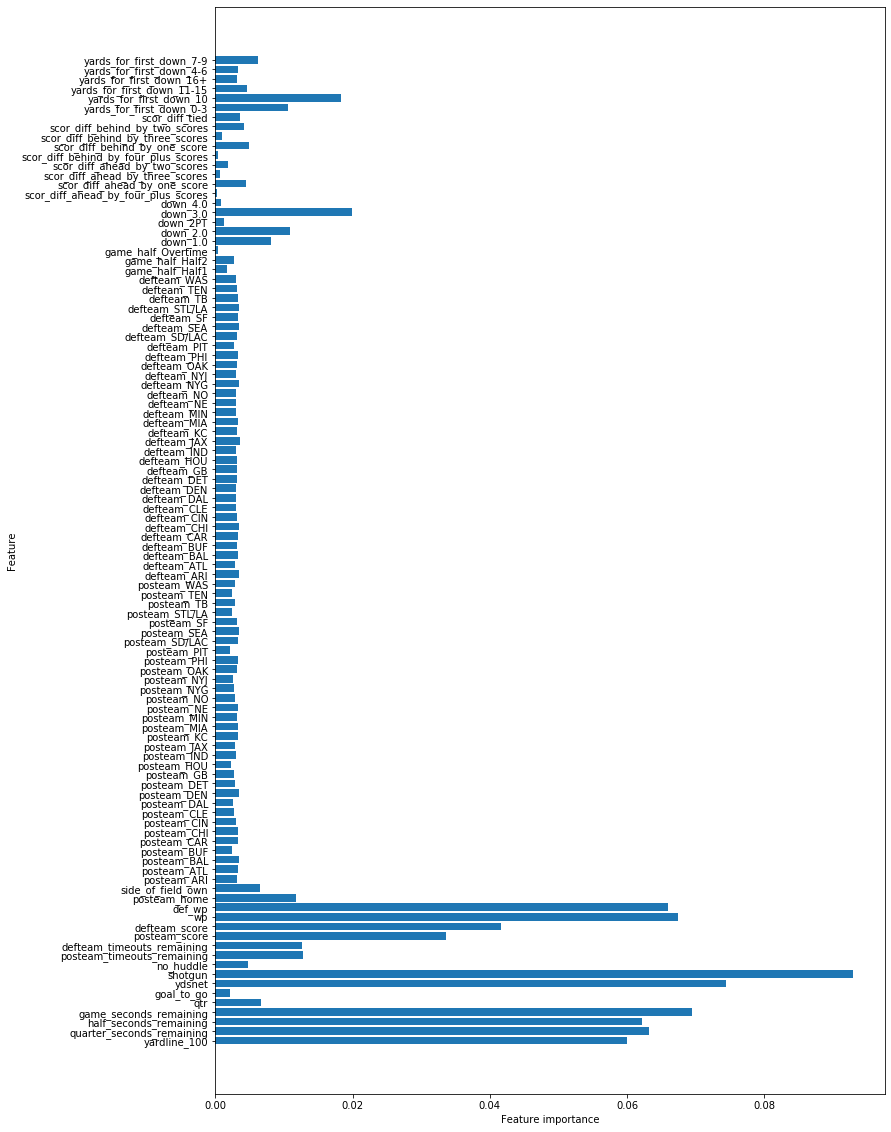

In [79]:
plot_feature_importances(classifier)

<Figure size 720x720 with 0 Axes>

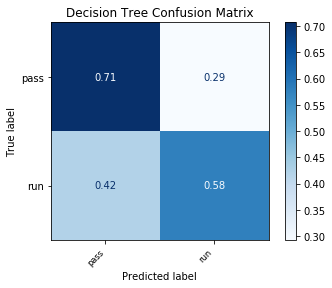

In [84]:
print_confusion_matrix(classifier, 'Decision Tree')

# Ensemble Methods

## Random Forests

In [23]:
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5,class_weight = 'balanced', random_state = 42) 
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

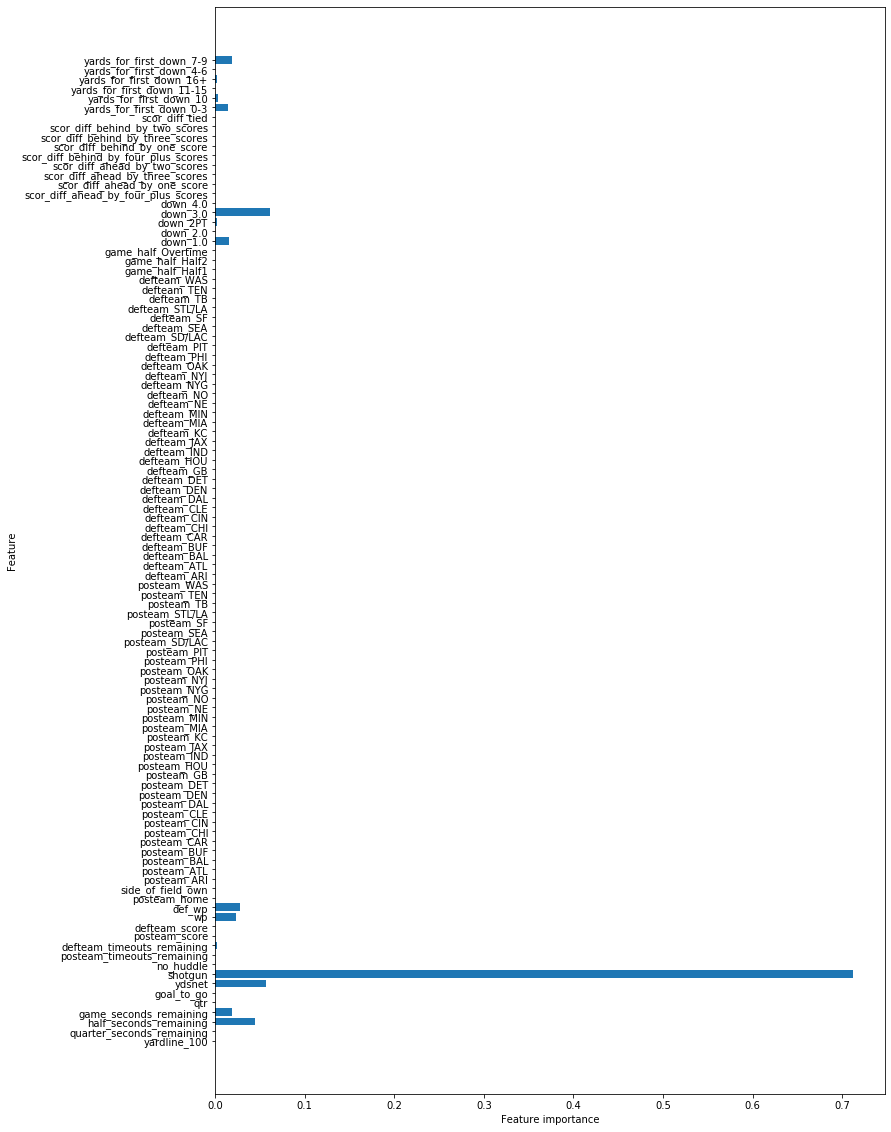

In [24]:
plot_feature_importances(tree_clf)

In [25]:
pred = tree_clf.predict(X_test)

In [26]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        pass       0.78      0.73      0.75     51490
         run       0.64      0.70      0.67     35995

    accuracy                           0.72     87485
   macro avg       0.71      0.71      0.71     87485
weighted avg       0.72      0.72      0.72     87485



In [29]:
print_metrics(y_test, pred)

Precision Score: 0.7210269088183946
Recall Score: 0.7164656798308281
Accuracy Score: 0.7164656798308281
F1 Score: 0.7178920913276582


<Figure size 720x720 with 0 Axes>

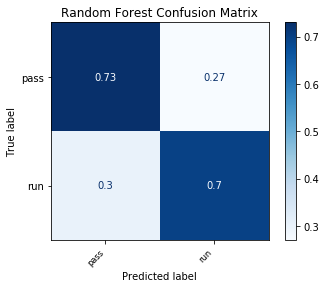

In [85]:
print_confusion_matrix(tree_clf, 'Random Forest')

## Bagging Tree

In [30]:
# Instantiate a BaggingClassifier
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5, class_weight = 'balanced', random_state = 42), 
                                 n_estimators=20)

In [31]:
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight='balanced',
                                                        criterion='gini',
                                                        max_depth=5,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=42,

In [34]:
pred = bagged_tree.predict(X_test)

In [35]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        pass       0.78      0.73      0.75     51490
         run       0.64      0.70      0.67     35995

    accuracy                           0.72     87485
   macro avg       0.71      0.71      0.71     87485
weighted avg       0.72      0.72      0.72     87485



In [36]:
print_metrics(y_test, pred)

Precision Score: 0.7214177825050232
Recall Score: 0.7162942218666057
Accuracy Score: 0.7162942218666057
F1 Score: 0.7178241228886053


<Figure size 720x720 with 0 Axes>

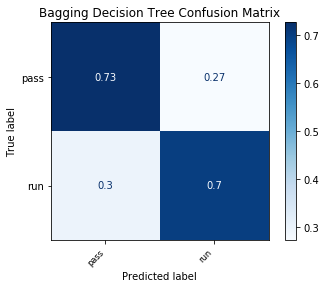

In [86]:
print_confusion_matrix(bagged_tree, 'Bagging Decision Tree')

In [37]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth= 5, class_weight = 'balanced', random_state = 42)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [38]:
pred = forest.predict(X_test)

In [39]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        pass       0.81      0.65      0.72     51490
         run       0.61      0.78      0.68     35995

    accuracy                           0.70     87485
   macro avg       0.71      0.72      0.70     87485
weighted avg       0.73      0.70      0.71     87485



In [40]:
print_metrics(y_test, pred)

Precision Score: 0.7268265633205537
Recall Score: 0.7048179687946505
Accuracy Score: 0.7048179687946505
F1 Score: 0.7069812443332454


<Figure size 720x720 with 0 Axes>

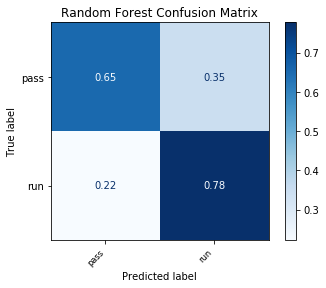

In [87]:
print_confusion_matrix(forest, 'Random Forest')

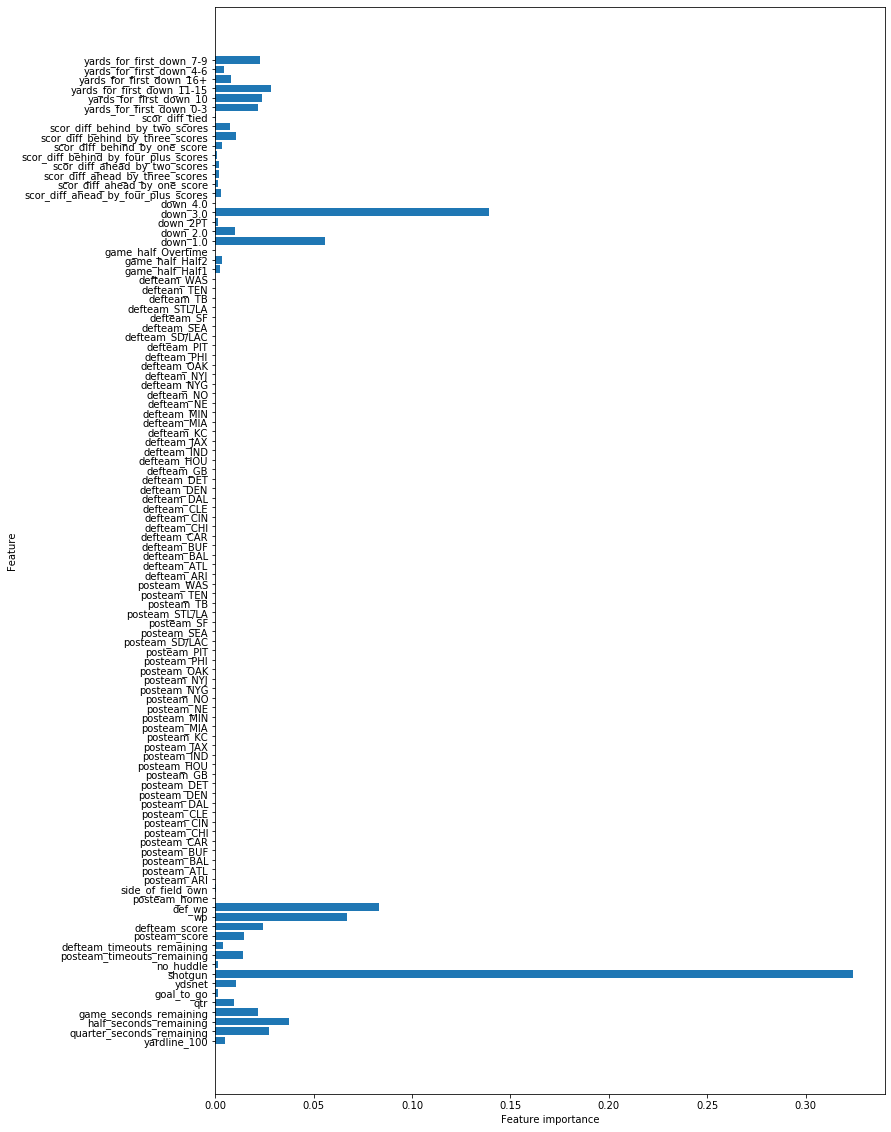

In [43]:
plot_feature_importances(forest)

# Gridsearch

In [44]:
dt_clf = DecisionTreeClassifier(random_state = 42, class_weight = 'balanced')

dt_cv_score = cross_val_score(dt_clf, X_train, y_train, cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 66.10%


In [45]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [47]:
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'cr

In [48]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])

# Mean test score
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 74.29%
Mean Test Score: 71.65%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [49]:
rf_clf = RandomForestClassifier(random_state = 42, class_weight = 'balanced')
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X_train, y_train, cv=3))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

Mean Cross Validation Score for Random Forest Classifier: 73.57%


In [50]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [51]:
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Training Accuracy: 73.97%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}


In [56]:
pred = rf_grid_search.predict(X_test)

In [57]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        pass       0.80      0.75      0.77     51490
         run       0.67      0.73      0.70     35995

    accuracy                           0.74     87485
   macro avg       0.73      0.74      0.74     87485
weighted avg       0.75      0.74      0.74     87485



In [60]:
print_metrics(y_test, pred)

Precision Score: 0.7454991109890873
Recall Score: 0.7413842372978224
Accuracy Score: 0.7413842372978224
F1 Score: 0.7426382666564447


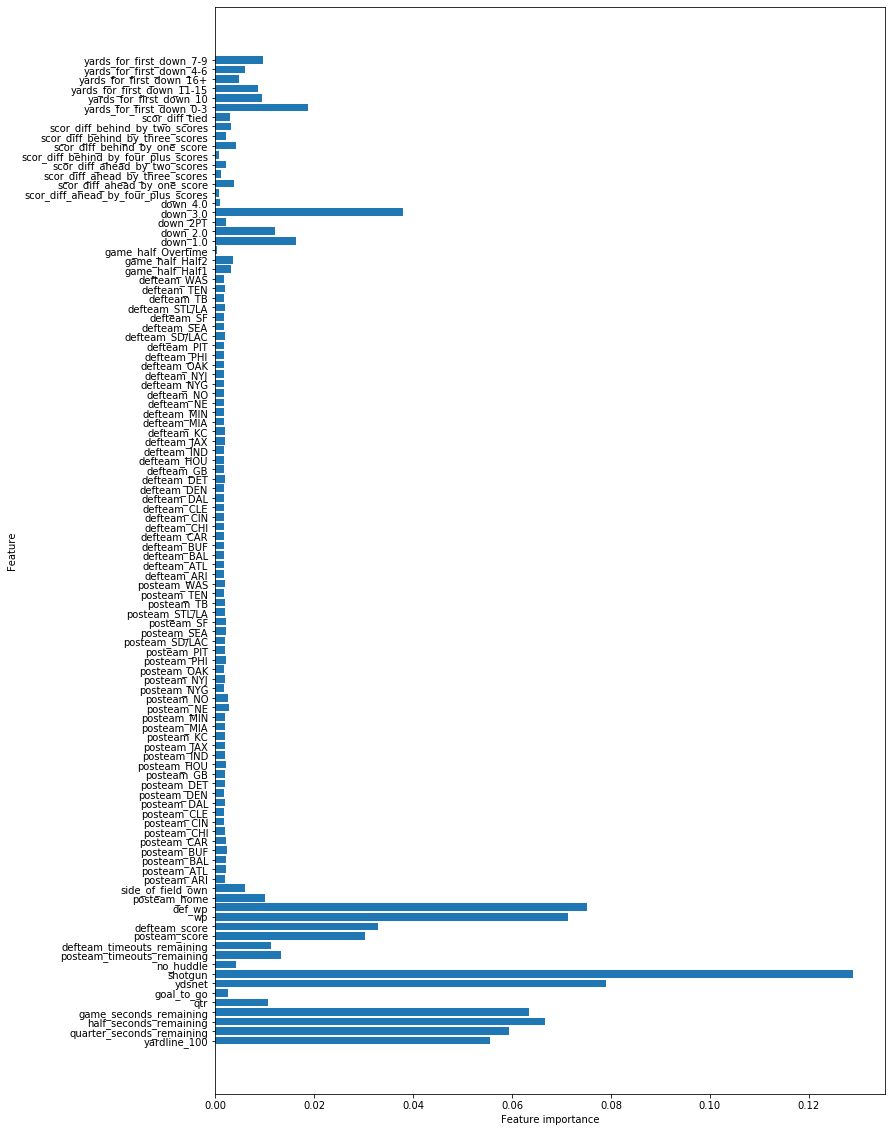

In [71]:
plot_feature_importances(rf_grid_search.best_estimator_)

<Figure size 720x720 with 0 Axes>

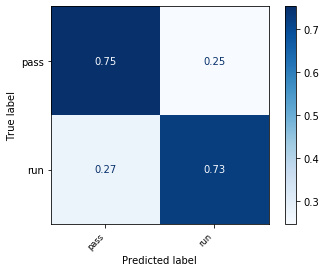

In [59]:
print_confusion_matrix(rf_grid_search)

# XGBoost

In [61]:
clf = xgb.XGBClassifier(random_state = 42)
clf.fit(X_train, y_train)
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 74.01%
Validation accuracy: 73.91%


In [62]:
param_grid = {
    "early_stopping_rounds": [10],
    "learning_rate": [0.1],
    'max_depth': [5,6],
    'min_child_weight': [10],
    'subsample': [0.75],
    'n_estimators': [200, 250],
}

In [63]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
early_stopping_rounds: 10
learning_rate: 0.1
max_depth: 6
min_child_weight: 10
n_estimators: 250
subsample: 0.75

Training Accuracy: 76.1%
Validation accuracy: 75.05%


In [64]:
print(classification_report(y_test, val_preds))

              precision    recall  f1-score   support

        pass       0.78      0.80      0.79     51490
         run       0.70      0.68      0.69     35995

    accuracy                           0.75     87485
   macro avg       0.74      0.74      0.74     87485
weighted avg       0.75      0.75      0.75     87485



In [65]:
print_metrics(y_test, val_preds)

Precision Score: 0.7495238372810585
Recall Score: 0.750494370463508
Accuracy Score: 0.750494370463508
F1 Score: 0.749895069804333


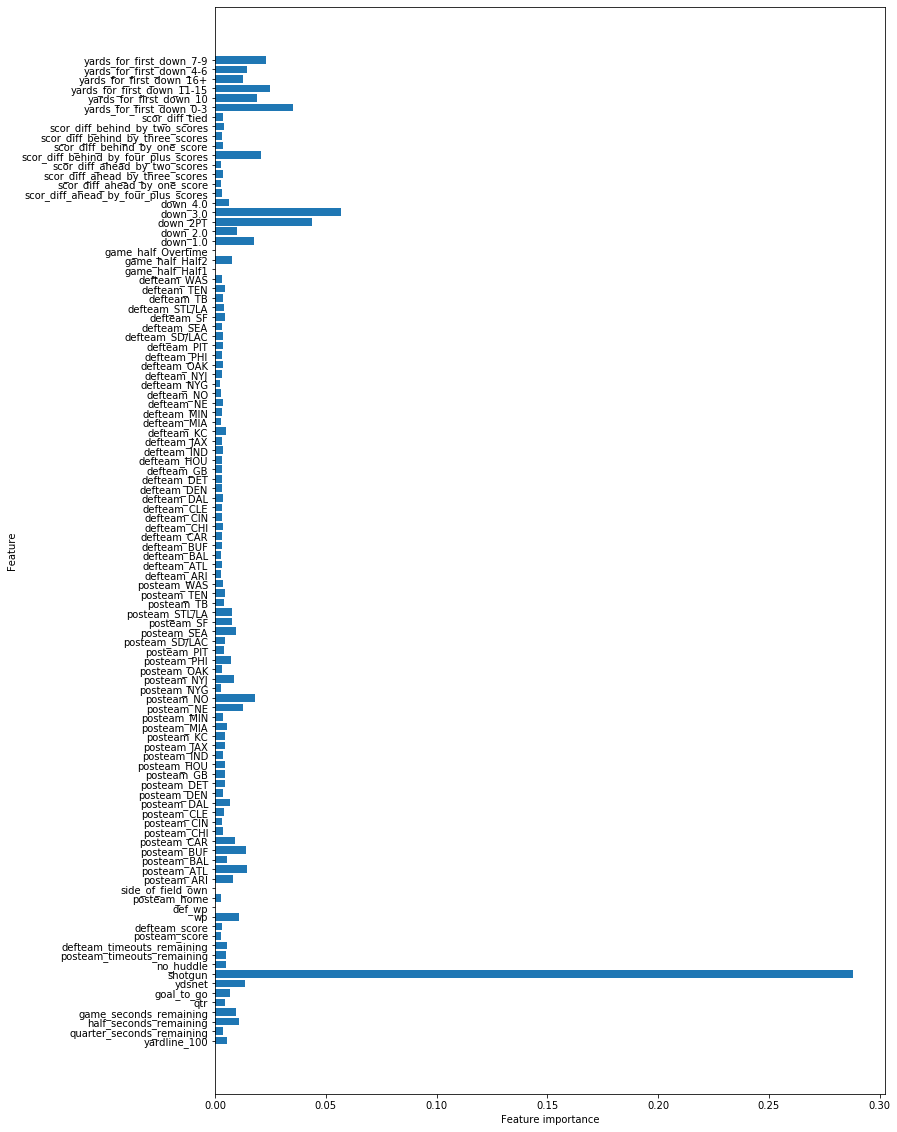

In [70]:
plot_feature_importances(grid_clf.best_estimator_)

<Figure size 720x720 with 0 Axes>

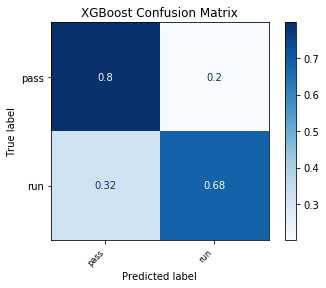

In [88]:
print_confusion_matrix(grid_clf, 'XGBoost')

# Final Results:

XGBoost performed the best of all models based on overall accuracy and pass recall.

![model_results_table](Images/model_results_table.png)